## Stage 01: Data Acquisition

In [4]:
# project path setup
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent # notebooks/ -> project root
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

In [6]:
# imports
import pandas as pd
import datetime as dt

### Time Duration Setup
Set the start date two years from today

In [8]:
from options_valuation.config import load_env, get_key
load_env()

def two_years_ago(today: dt.date) -> dt.date:
    """Return the date ~2 years before today, safe for leap days."""
    try:
        return today.replace(year=today.year - 2)
    except ValueError:
        # Handles Feb 29 -> Feb 28
        return today.replace(month=2, day=28, year=today.year - 2)

today = dt.date.today()
start_date = two_years_ago(today)
end_date = today

print("Today:", today)
print("Start date (2Y):", start_date)
print("End date:", end_date)


Today: 2026-01-08
Start date (2Y): 2024-01-08
End date: 2026-01-08


### Stock Ticker Setup
Ask the user to enter a stock ticker, with a default of .env DEFAULT_TICKER or "DIS" (Disney). The program will validate the ticker using the yfinance library.

In [10]:
from options_valuation.data.validators import validate_ticker

default_ticker = get_key("DEFAULT_TICKER", default = "DIS")

while True:
    raw = input(f"Enter stock ticker (default {default_ticker}): ").strip()
    ticker = raw.upper() if raw else default_ticker

    if validate_ticker(ticker):
        break
    else:
        print(f"'{ticker}' is not a valid ticker. Try again.")

Enter stock ticker (default DIS):  APPL


'APPL' is not a valid ticker. Try again.


Enter stock ticker (default DIS):  AAPL


### Data Retrieval
Fetch Alpha Vantage for stock data using the API key first, and then fall back to yfinance.

In [12]:
from typing import Tuple
from options_valuation.data.providers import (
    fetch_alpha_vantage,
    fetch_yfinance,
)


def get_price_data(
    ticker: str,
    start: dt.date,
    end: dt.date,
) -> Tuple[pd.DataFrame, str]:
    """
    Try Alpha Vantage first, fallback to yfinance.
    Returns (dataframe, provider_name).
    """
    api_key = get_key("API_KEY", default=None)

    # Try Alpha Vantage if key exists
    if api_key:
        try:
            df = fetch_alpha_vantage(ticker, api_key, start, end)
            return df, "alpha_vantage"
        except Exception as e:
            print(f"[WARN] Alpha Vantage failed, falling back to yfinance. Reason: {e}")

    # Fallback to yfinance
    df = fetch_yfinance(ticker, start, end)
    return df, "yfinance"

data, provider = get_price_data(ticker, start_date, end_date)
print("Provider used:", provider)

{'Information': 'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}
[WARN] Alpha Vantage failed, falling back to yfinance. Reason: Unexpected response keys: ['Information']
Provider used: yfinance


### Data Storage
Store the stock data in data/raw/ folder

In [18]:
from pathlib import Path
from options_valuation.config import data_dir

def save_raw_data(
    df,
    ticker: str,
    provider: str,
    start_date,
    end_date,
):

    """
    Create data/raw/ folder to collect raw data
    """
    base_dir = Path(data_dir())
    raw_dir = base_dir / "raw"
    raw_dir.mkdir(parents=True, exist_ok =True)

    """
    RThe rw data file is named:
    {TICKER}_{PROVIDER}_daily_{START}_{END}.csv
    """
    filename = (
        f"{ticker}_{provider}_daily_"
        f"{start_date}_{end_date}.csv"
    )

    out_path = raw_dir / filename
    df.to_csv(out_path, index=False)

    return out_path

def cleanup_old_price_files(
    raw_dir: Path,
    ticker: str,
    frequency: str = "daily",
):

    """
    Remove older CSV files for the same ticker and frequency.
    Keep only the most recent file (by modified time).
    """
    pattern = f"{ticker}_*_{frequency}_*_.csv"
    files = sorted(
        raw_dir.glob(pattern),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )

    # If there are 0 or 1 files, there's nothing to delete
    if len(files) <= 1:
        print(f"[Cleanup] Nothing to remove for {ticker} ({frequency}).")
    
    for old_file in files[1:]:
        old_file.unlink()
        print(f"[Cleanup] Removed old file(s): {old_file.name}")

    return

out_path = save_raw_data(
    data,
    ticker=ticker,
    provider=provider,
    start_date=start_date,
    end_date=end_date,
)

print("Saved to: ", out_path)
data.head()

# Cleanup older versions (other stock data are not affected)
cleanup_old_price_files(
    raw_dir=out_path.parent,
    ticker=ticker,
    frequency="daily",
)

Saved to:  /Users/allenpilipala/BSM_model/data/raw/AAPL_yfinance_daily_2024-01-08_2026-01-08.csv
[Cleanup] Nothing to remove for AAPL (daily).


## Historical Price Change Diagram
Draw a diagram showing the price change within the past two years

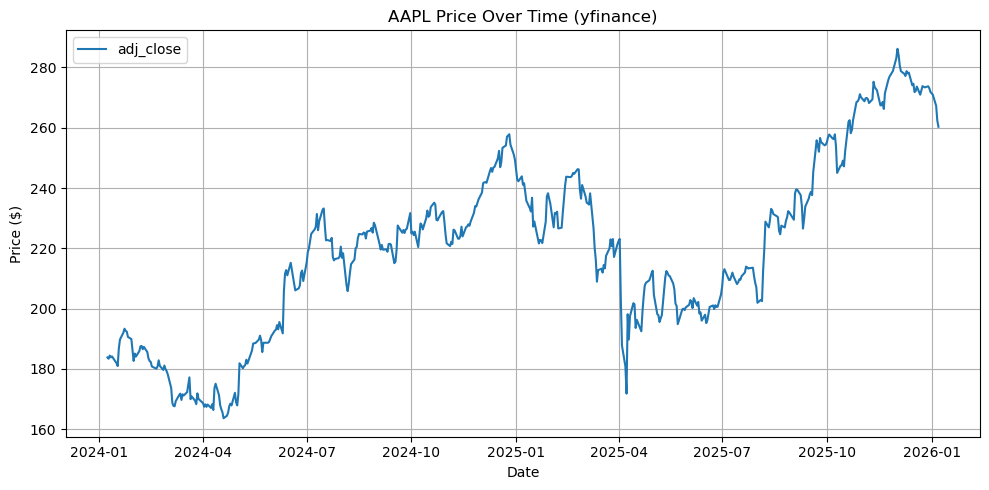

Price plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_price_yfinance_daily.png


In [16]:
import matplotlib.pyplot as plt
from pathlib import Path
from options_valuation.config import data_dir

# Choose price column
price_col = "adj_close" if "adj_close" in data.columns else "close"

# Prepare docs directory
docs_dir = Path(data_dir()).parent / "docs"
docs_dir.mkdir(parents=True, exist_ok=True)

# Plot price
plt.figure(figsize=(10, 5))
plt.plot(data["date"], data[price_col], label=price_col)
plt.title(f"{ticker} Price Over Time ({provider})")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_price_{provider}_daily.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Price plot saved to:", out_path)